## Description

We Achieved 0.883664 with this model at 69000 iterations (z value not number of epochs which is 47) 

Net Prameters:
1. Batch size = 16 with shuffling but gradient update every four batches thus makig it viturally a btach size of 64

2. Learning Rate = Dynamic using Adam

3. Input dimensions = [-1,3,240,320]

4. Output dimensions = [-1,4]          
    ie.[batch_size,x1,y1,x2,y2]

Image transformations:
1. Resizing by half 
2. Normalisation

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from skimage import io, transform
import torch.optim as optim
import os
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import cv2

torch.backends.cudnn.deterministic=True
torch.cuda.manual_seed_all(999)
torch.manual_seed(999)
np.random.seed(999)



In [2]:
class FlipkartDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.coords_frame = pd.read_csv(csv_file,header=0)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.coords_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.coords_frame.loc[idx,:]["image_name"])
        image = cv2.imread(img_name)
        image = cv2.resize(image, dsize=(320,240), interpolation=cv2.INTER_CUBIC)
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        coords=[]
        coords=torch.tensor(np.array([int(self.coords_frame.loc[idx,:]["x1"]),
                int(self.coords_frame.loc[idx,:]["y1"]),
                int(self.coords_frame.loc[idx,:]["x2"]),
                int(self.coords_frame.loc[idx,:]["y2"])]))
        X=image
        y=coords
        
        return X,y
    

train_params = {'batch_size': 16,
          'shuffle': True}
valid_params = {'batch_size': 16,
          'shuffle': False}

sampler_1=FlipkartDataset("Dataset/train_split.csv","Dataset/images/")
training_generator = data.DataLoader(sampler_1, **train_params)

sampler_2=FlipkartDataset("Dataset/valid_split.csv","Dataset/images/")
validation_generator = data.DataLoader(sampler_2, **valid_params)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input dim (3*240*320)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv1_bn = nn.BatchNorm2d(num_features=16)
        # 16*240*320
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,padding=1)
        # 16*120*160
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,)
        self.conv2_bn = nn.BatchNorm2d(num_features=32)
        # 32*120*160
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2,padding=1)
        # 32*60*80
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(num_features=64)
        # 64*60*80
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2,padding=1)
        # 64*30*40
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4_bn = nn.BatchNorm2d(num_features=128)
        # 128*30*40
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2,padding=1)
        # 128*15*20
        
        #self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        #self.conv5_bn = nn.BatchNorm2d(num_features=256)
        # 256*60*80
        #self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2,padding=1)
        # 256*15*20
        
        self.fc1 = nn.Linear(128*15*20,2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 4)
        

    def forward(self, x):
        x = self.pool1(self.conv1_bn(F.relu(self.conv1(x))))
        x = self.pool2(self.conv2_bn(F.relu(self.conv2(x))))
        x = self.pool3(self.conv3_bn(F.relu(self.conv3(x))))
        x = self.pool4(self.conv4_bn(F.relu(self.conv4(x))))
        #x = self.pool5(F.relu(self.conv5(x)))
        #x = self.pool5(F.relu(self.conv5_bn(self.conv5(x))))
        x = x.view(-1,128*15*20)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Epoch: 47  Total No of batches run: 69410
No of 64 batches run: 17352
Training Loss: 9.321002006530762
Validation Loss: 37.605464935302734


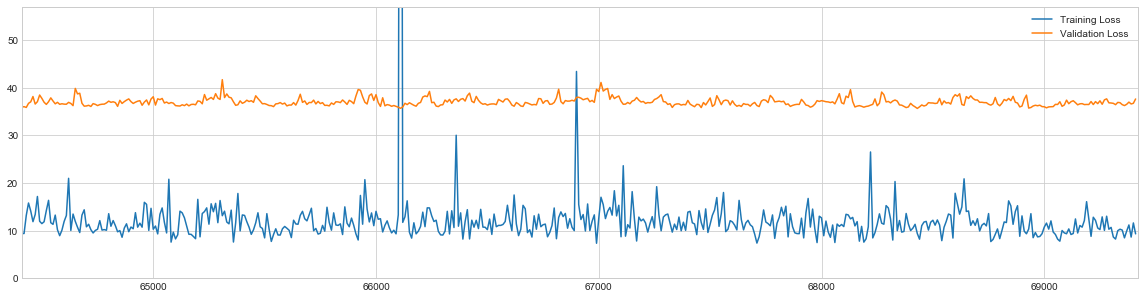

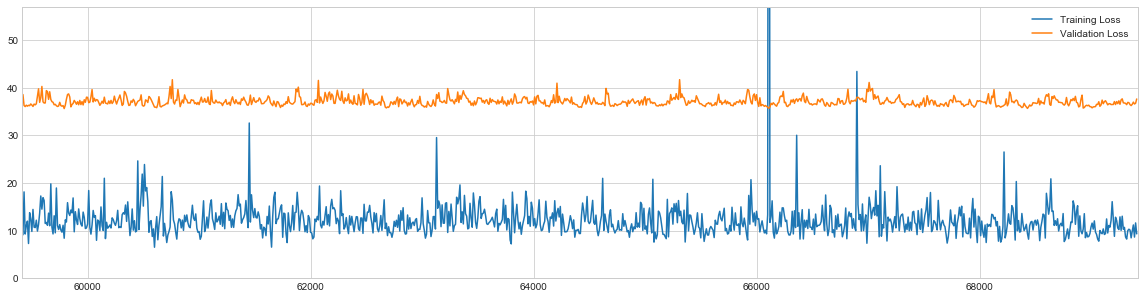

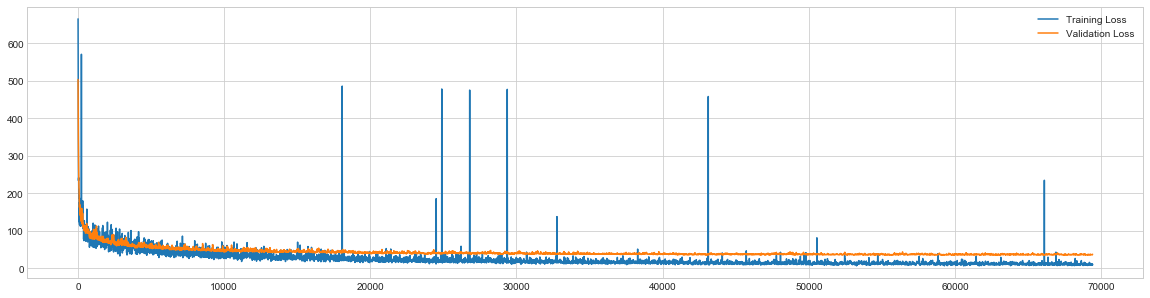

tensor([[ 18.,  51., 617., 396.],
        [138.,   8., 626., 251.],
        [128., 188., 499., 326.],
        [ 71.,  16., 482., 455.],
        [ 25., 100., 629., 360.],
        [ 64.,  68., 598., 468.],
        [ 52.,  67., 549., 376.],
        [ 98., 149., 489., 340.],
        [191., 117., 505., 372.],
        [ 37., 123., 553., 384.],
        [134.,  72., 500., 336.],
        [198., 117., 401., 286.],
        [129., 153., 524., 320.],
        [126.,   0., 640., 480.],
        [216., 172., 417., 351.],
        [ 96., 100., 453., 344.]], device='cuda:0')
tensor([[ 17.2121,  51.0172, 618.2603, 400.5622],
        [142.8939,   6.8645, 622.3007, 261.1236],
        [123.3902, 178.3990, 496.9706, 326.7650],
        [ 67.3868,   6.2622, 479.8036, 454.6146],
        [ 21.5761,  92.7156, 635.7945, 361.1923],
        [ 63.6174,  65.0995, 593.2520, 466.1187],
        [ 50.3096,  62.3743, 544.8409, 383.5466],
        [ 98.8679, 143.7558, 482.0058, 334.8448],
        [190.0585, 114.8828, 497.2578,

KeyboardInterrupt: 

In [4]:
class Dist_Loss(torch.nn.Module):
    
    def __init__(self):
        super(Dist_Loss,self).__init__()
        
    def forward(self,a,b):
        
        return torch.mean(torch.sqrt(torch.sum((a[:,0:2]-b[:,0:2])**2,1))+torch.sqrt(torch.sum((a[:,2:4]-b[:,2:4])**2,1)))
    
net=Net().cuda()
criterion=Dist_Loss().cuda()
optimizer=optim.Adam(net.parameters(),lr=0.001)
z=0


# If we are resuming training
resume_train=False
# the iter number to start from (its in the wieghts file name)
iter_no=59000


if resume_train:
        checkpoint = torch.load("models/Mach_1/Run_3/model"+str(iter_no)+"_batch_64_.pt")
        net.load_state_dict(checkpoint['state_dict'])
        net.cuda()
        optimizer.load_state_dict(checkpoint['optimizer'])
        z=iter_no

        
loss_idx=list()
valid_loss_idx=list()
batch_idx=list()
minn=7

# zero the parameter gradients
optimizer.zero_grad()
valid_loss=torch.tensor([999]).type('torch.FloatTensor')

for epoch in range(0,5000):
    for X,y in training_generator:
            z+=1
            
            #Loading Inputs
            X = X.type('torch.FloatTensor') 
            X=X.transpose(3,1)
            X=X.transpose(2,3)
            
            X=X.cuda()
            #Loading Targets
            y=y.type('torch.FloatTensor')
            y=y.cuda()
            
            outputs = net(X)
            
            
            loss=criterion(outputs,y)
            loss=loss/4
            loss.backward()
            
            # To run optimizer only every 4 steps thus simulating four times the batch size 
            if z%4==1:
                train_actual_loss=loss.item()*4
                optimizer.step()
                optimizer.zero_grad()
                
            

            
            
            
            
            if z %10==0:
                
                loss_idx.append(train_actual_loss)
                batch_idx.append(z)
                
                valid_loss=torch.tensor([]).type('torch.FloatTensor') 
                for X_valid,y_valid in validation_generator:
                    X_valid = X_valid.type('torch.FloatTensor') 
                    X_valid=X_valid.transpose(3,1)
                    X_valid=X_valid.transpose(2,3)

                    X_valid=X_valid.cuda()
                    #Loading Targets
                    y_valid=y_valid.type('torch.FloatTensor')
                    y_valid=y_valid.cuda()
                    outputs_valid = net(X_valid)
                    
                    valid_loss=torch.cat((valid_loss,torch.tensor([criterion(outputs_valid,y_valid)])),0)
                    
                valid_loss=valid_loss.mean()
                
                valid_loss_idx.append(valid_loss.item())      
                      
                      
                grid=pd.DataFrame({"Batch":batch_idx,"Train_Loss":loss_idx,"Valid_Loss":valid_loss_idx})
                grid.to_csv("Training_Loss.csv",index=None)
                clear_output()
                #Stats
                print('Epoch:',epoch,' Total No of batches run:',str(int(z)))
                print('No of 64 batches run:',str(int(z/4)))
                print('Training Loss:',train_actual_loss)
                print('Validation Loss:',valid_loss.item())
                top_loss=max(valid_loss,train_actual_loss)
                # Plot 1
                plt.figure(figsize=(20,5))
                plt.ylim(0,int(top_loss)+20)
                plt.xlim(z-5000, z+10)
                plt.plot(batch_idx,loss_idx)
                plt.plot(batch_idx,valid_loss_idx)
                plt.legend(['Training Loss','Validation Loss'])
                plt.show()
                
                # Plot 2
                plt.figure(figsize=(20,5))
                plt.ylim(0,int(top_loss)+20)
                plt.xlim(z-10000, z+10)
                plt.plot(batch_idx,loss_idx)
                plt.plot(batch_idx,valid_loss_idx)
                plt.legend(['Training Loss','Validation Loss'])
                plt.show()
                
                # Plot 2
                plt.figure(figsize=(20,5))
                plt.plot(batch_idx,loss_idx)
                plt.plot(batch_idx,valid_loss_idx)
                plt.legend(['Training Loss','Validation Loss'])
                plt.show()
                
                # Print the outputs
                print(y)
                print(outputs)
            
            if valid_loss<minn :
                minn=valid_loss
                torch.save({
                            'epoch': epoch + 1,
                            'state_dict': net.state_dict(),
                            'optimizer' : optimizer.state_dict(),
                            }, "models/Mach_1/model"+str(z)+"_loss_"+str(minn)+"_batch_64_.pt")
                      
            if z % 1000==0:
                torch.save({
                            'epoch': epoch + 1,
                            'state_dict': net.state_dict(),
                            'optimizer' : optimizer.state_dict(),
                            }, "models/Mach_1/model"+str(z)+"_batch_64_.pt")